# Train Clamer Model with Pre-setting Vocab

In [1]:
# change to the directory of the script
%cd ..

/home/hudongcheng/Desktop/bo_osda_generator


In [2]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm import tqdm
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import torch.backends.cudnn as cudnn

# import custom modules
from datasets.data_loader import *
from models.clamer import *
from models.loss import InfoNCELoss
from models.trfm import *
from utils.utils import *
from utils.plot_figures import *
from utils.metrics import *
from utils.build_vocab import *

In [3]:
cudnn.benchmark = True
cudnn.enabled = True

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
train_ce_loss_history = []
test_ce_loss_history = []
train_info_loss_history = []
test_info_loss_history = []

log_dir = './logs/'
save_best_weight_path = './checkpoints/'

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [4]:
PAD = 0
UNK = 1
EOS = 2
SOS = 3
MASK = 4
MAX_LEN = 220

In [5]:
# read the data from the file
train_data = pd.read_csv('./data/train_contrastive_dataset.csv')
test_data = pd.read_csv('./data/test_contrastive_dataset.csv')

vocab = WordVocab.load_vocab('./model_hub/vocab.pkl')
print('the vocab size is :', len(vocab))

charlen = len(vocab)
print('the total num of charset is :', charlen)

the vocab size is : 45
the total num of charset is : 45


In [6]:
# hyperparameters
d_model = 128
head = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64
epoch = 10

In [7]:
# create the dataset and dataloader
# train_dataset = Contrastive_Seq2seqDataset(train_data, vocab, MAX_LEN)
# test_dataset = Contrastive_Seq2seqDataset(test_data, vocab, MAX_LEN)
train_dataset = Contrastive_Seq2seqDataset_random(train_data, vocab, MAX_LEN)
test_dataset = Contrastive_Seq2seqDataset_random(test_data, vocab, MAX_LEN)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# load model
model = GptCovd(d_model=d_model, charlen=charlen, device=device, head=head).to(device, non_blocking=True)

# load model
trfm = TrfmSeq2seq(charlen, 256, charlen, 4).to(device)
trfm.load_state_dict(torch.load('./model_hub/trfm_new_2_10000.pkl'))
trfm.eval()

# set trfm gradient to false which won't be updated
for param in trfm.parameters():
    param.requires_grad = False

# loss
loss_func = torch.nn.CrossEntropyLoss(ignore_index=PAD)
optim = torch.optim.Adam(model.parameters(), lr=6e-4)
total = sum(p.numel() for p in model.parameters())
print('total parameters: %0.2fM' % (total / 1e6))

100%|██████████| 14803/14803 [00:00<00:00, 52069.92it/s]


total parameters: 1.34M


In [8]:
# train function
def train(model, trfm, train_dataloader, loss_func, optim, device, weight=0.1):
    model.train()
    total_loss = 0
    total_loss_crossentropy = 0
    total_loss_infonce = 0
    total_acc = 0
    total_num = 0
    for i, (zeo, syn, tgt, positive_smiles, negative_smiles) in enumerate(tqdm(train_dataloader)):
        zeo = zeo.to(device)
        syn = syn.to(device)
        tgt = tgt.to(device)
        positive_smiles = positive_smiles.to(device)
        negative_smiles = negative_smiles.to(device)
        
        tgt_input = tgt[:, :-1].contiguous()
        tgt_label = tgt[:, 1:].contiguous()
        
        # forward
        optim.zero_grad()
        # ignore the first two tokens becauese thay are condition tokens
        output = model(zeo, syn, tgt_input)
        logits = output[:, 2:, :].to(device, non_blocking=True).contiguous()
        
        # Compute CrossEntropy Loss
        logits_reshaped = logits.view(-1, logits.size(-1))
        tgt_label_reshaped = tgt_label.view(-1)
        loss_ce = loss_func(logits_reshaped, tgt_label_reshaped)
        
        # calculate the accuracy
        pred = torch.argmax(logits, dim=-1)
        num_correct = (pred == tgt_label) & (tgt_label != PAD)
        num_words = (tgt_label != PAD).sum().item()
        
        # Gumbel-Softmax Sampling
        # logits: [batch_size, seq_len, vocab_size]
        samples = F.gumbel_softmax(logits, tau=1.0, hard=True)
        samples_indices = samples.argmax(dim=-1) # [batch_size, seq_len]
        # add the start token to the samples
        stared_token = torch.ones(samples_indices.size(0), 1, dtype=torch.long).fill_(SOS).to(device)
        samples_indices = torch.cat([stared_token, samples_indices], dim=-1)
        
        # Compute InfoNCE Loss
        loss_infonce = InfoNCELoss(samples_indices, positive_smiles, negative_smiles, trfm, temperature=0.07)
        
        # combine the two loss
        loss = loss_ce + weight * loss_infonce
        
        # backward
        loss.backward()
        optim.step()
        
        # statistics
        total_loss += loss.item()
        total_loss_crossentropy += loss_ce.item()
        total_loss_infonce += loss_infonce.item()
        total_acc += num_correct.sum().item()
        total_num += num_words
    return total_loss / len(train_dataloader), total_acc / total_num, total_loss_crossentropy / len(train_dataloader), total_loss_infonce / len(train_dataloader)

In [9]:
def evaluate(model, trfm, test_dataloader, loss_func, device, weight=0.1):
    model.eval()
    total_loss = 0
    total_loss_crossentropy = 0
    total_loss_infonce = 0
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for i, (zeo, syn, tgt, positive_smiles, negative_smiles) in enumerate(tqdm(test_dataloader)):
            zeo = zeo.to(device)
            syn = syn.to(device)
            tgt = tgt.to(device)
            positive_smiles = positive_smiles.to(device)
            negative_smiles = negative_smiles.to(device)
            
            tgt_input = tgt[:, :-1].contiguous()
            tgt_label = tgt[:, 1:].contiguous()
            
            # forward
            # ignore the first two tokens becauese thay are condition tokens
            output = model(zeo, syn, tgt_input)
            logits = output[:, 2:, :].to(device, non_blocking=True).contiguous()
            
            # Compute CrossEntropy Loss
            logits_reshaped = logits.view(-1, logits.size(-1))
            tgt_label_reshaped = tgt_label.view(-1)
            loss_ce = loss_func(logits_reshaped, tgt_label_reshaped)
            
            # calculate the accuracy
            pred = torch.argmax(logits, dim=-1)
            num_correct = (pred == tgt_label) & (tgt_label != PAD)
            num_words = (tgt_label != PAD).sum().item()
            
            # Gumbel-Softmax Sampling
            # logits: [batch_size, seq_len, vocab_size]
            samples = F.gumbel_softmax(logits, tau=1.0, hard=True)
            samples_indices = samples.argmax(dim=-1) # [batch_size, seq_len]
            # add the start token to the samples
            stared_token = torch.ones(samples_indices.size(0), 1, dtype=torch.long).fill_(SOS).to(device)
            samples_indices = torch.cat([stared_token, samples_indices], dim=-1)
            
            # Compute InfoNCE Loss
            loss_infonce = InfoNCELoss(samples_indices, positive_smiles, negative_smiles, trfm, temperature=0.07)
            
            # combine the two loss
            loss = loss_ce + loss_infonce
            
             # statistics
            total_loss += loss.item()
            total_loss_crossentropy += loss_ce.item()
            total_loss_infonce += loss_infonce.item()
            total_acc += num_correct.sum().item()
            total_num += num_words
    return total_loss / len(test_dataloader), total_acc / total_num, total_loss_crossentropy / len(test_dataloader), total_loss_infonce / len(test_dataloader)

In [10]:
# train the model
for i in range(epoch):
    train_loss, train_acc, train_ce, train_info = train(model, trfm, train_dataloader, loss_func, optim, device)
    # train_loss, train_acc, train_ce, train_info = train(model, trfm, test_dataloader, loss_func, optim, device)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    train_ce_loss_history.append(train_ce)
    train_info_loss_history.append(train_info)
    print('epoch: %d, train loss: %.4f, train acc: %.4f, train crossentropy loss: %.4f, train infonce loss: %.4f' % (i, train_loss, train_acc, train_ce, train_info))
    test_loss, test_acc, test_ce, test_info = evaluate(model, trfm, test_dataloader, loss_func, device)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    test_ce_loss_history.append(test_ce)
    test_info_loss_history.append(test_info)
    print('epoch: %d test loss: %.4f, test acc: %.4f, test crossentropy loss: %.4f, test infonce loss: %.4f' % (i, test_loss, test_acc, test_ce, test_info))
    if i == 0:
        best_acc = test_acc
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), save_best_weight_path + 'best_clamer_contrastive_model.pth')
    torch.save(model.state_dict(), save_best_weight_path + 'last_clamer_contrastive_model.pth')
    
    # save every epoch model to clamer folder
    torch.save(model.state_dict(), save_best_weight_path + '/clamer/clamer_contrastive_model_' + str(i) + '.pth')

100%|██████████| 2265/2265 [19:17<00:00,  1.96it/s]


epoch: 0, train loss: 1.2308, train acc: 0.7187, train crossentropy loss: 0.7880, train infonce loss: 4.4277


100%|██████████| 232/232 [01:54<00:00,  2.03it/s]


epoch: 0 test loss: 4.9305, test acc: 0.7938, test crossentropy loss: 0.5515, test infonce loss: 4.3790


100%|██████████| 2265/2265 [19:18<00:00,  1.96it/s]


epoch: 1, train loss: 0.9566, train acc: 0.8004, train crossentropy loss: 0.5161, train infonce loss: 4.4050


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 1 test loss: 4.8310, test acc: 0.8232, test crossentropy loss: 0.4603, test infonce loss: 4.3707


100%|██████████| 2265/2265 [19:17<00:00,  1.96it/s]


epoch: 2, train loss: 0.8803, train acc: 0.8245, train crossentropy loss: 0.4409, train infonce loss: 4.3937


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 2 test loss: 4.7705, test acc: 0.8375, test crossentropy loss: 0.4142, test infonce loss: 4.3563


100%|██████████| 2265/2265 [19:18<00:00,  1.96it/s]


epoch: 3, train loss: 0.8406, train acc: 0.8366, train crossentropy loss: 0.4016, train infonce loss: 4.3900


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 3 test loss: 4.7410, test acc: 0.8461, test crossentropy loss: 0.3865, test infonce loss: 4.3545


100%|██████████| 2265/2265 [19:18<00:00,  1.96it/s]


epoch: 4, train loss: 0.8156, train acc: 0.8444, train crossentropy loss: 0.3768, train infonce loss: 4.3884


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 4 test loss: 4.7279, test acc: 0.8501, test crossentropy loss: 0.3729, test infonce loss: 4.3550


100%|██████████| 2265/2265 [19:17<00:00,  1.96it/s]


epoch: 5, train loss: 0.7980, train acc: 0.8496, train crossentropy loss: 0.3592, train infonce loss: 4.3874


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 5 test loss: 4.7127, test acc: 0.8546, test crossentropy loss: 0.3584, test infonce loss: 4.3543


100%|██████████| 2265/2265 [19:17<00:00,  1.96it/s]


epoch: 6, train loss: 0.7846, train acc: 0.8538, train crossentropy loss: 0.3459, train infonce loss: 4.3871


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 6 test loss: 4.6919, test acc: 0.8563, test crossentropy loss: 0.3483, test infonce loss: 4.3435


100%|██████████| 2265/2265 [19:17<00:00,  1.96it/s]


epoch: 7, train loss: 0.7740, train acc: 0.8571, train crossentropy loss: 0.3352, train infonce loss: 4.3877


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 7 test loss: 4.6951, test acc: 0.8590, test crossentropy loss: 0.3402, test infonce loss: 4.3549


100%|██████████| 2265/2265 [19:18<00:00,  1.96it/s]


epoch: 8, train loss: 0.7658, train acc: 0.8598, train crossentropy loss: 0.3267, train infonce loss: 4.3913


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 8 test loss: 4.6982, test acc: 0.8594, test crossentropy loss: 0.3357, test infonce loss: 4.3625


100%|██████████| 2265/2265 [19:18<00:00,  1.96it/s]


epoch: 9, train loss: 0.7591, train acc: 0.8620, train crossentropy loss: 0.3193, train infonce loss: 4.3980


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]

epoch: 9 test loss: 4.7005, test acc: 0.8615, test crossentropy loss: 0.3292, test infonce loss: 4.3713


In [11]:
# # load the last model
# model = GptCovd(d_model=d_model, charlen=charlen, device=device, head=head).to(device, non_blocking=True)
# model.load_state_dict(torch.load('./checkpoints/clamer/clamer_contrastive_model_9.pth'))

In [12]:
def generate_clamer(model, start_sequence, zeo, syn, max_length, vocab, device, temperature=1.0, top_k=0):
    """
    Autoregressive generation process for a GPT model.

    Args:
        model (CLAMER): The pre-trained GPT model for token generation.
        start_sequence (torch.Tensor): The initial sequence to start generation (batch_size, seq_length).
        zeo (torch.Tensor): The zeolite condition tensor.
        syn (torch.Tensor): The synthesis condition tensor.
        max_length (int): The maximum length of the generated sequence.
        vocab: The vocabulary object for encoding and decoding SMILES strings.
        device (torch.device): The device on which to run the generation.
        temperature (float): Temperature parameter for sampling; higher values increase randomness.
        top_k (int): Limits sampling to top-k logits; if 0, no top-k sampling is applied.

    Returns:
        List[str]: A list of generated SMILES strings.
    """
    model.eval()
    batch_size = start_sequence.size(0)
    generated_sequences = start_sequence.clone().to(device)  # Clone and move to device
    # expand generated_sequences to the max_length with padding tokens
    padding = torch.full((batch_size, max_length - generated_sequences.size(1)), PAD, dtype=torch.long).to(device)
    generated_sequences_input = torch.cat([generated_sequences, padding], dim=1)[:,:-1].to(device)
    
    with torch.no_grad():
        # Forward pass through the
        for current_len in range(max_length - start_sequence.size(1)):
            
            # Forward pass through the model
            logits = model(zeo, syn, generated_sequences_input)
            # Extract the logits for the last time step
            next_token_logits = logits[:, -1, :]  # (batch_size, vocab_size)

            # Apply temperature scaling
            next_token_logits = next_token_logits / temperature

            # Apply top-k filtering
            if top_k > 0:
                top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k, dim=-1)
                mask = torch.full_like(next_token_logits, float('-inf'))
                mask.scatter_(dim=-1, index=top_k_indices, src=top_k_logits)
                next_token_logits = mask

            # Convert logits to probabilities
            next_token_probs = F.softmax(next_token_logits, dim=-1)

            # Sample from the probability distribution
            next_token = torch.multinomial(next_token_probs, num_samples=1)  # (batch_size, 1)
            
            # Get the most likely next token
            # next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

            # Append the generated token to the sequence
            generated_sequences = torch.cat([generated_sequences, next_token], dim=1)
            # update the input sequence for the next iteration
            generated_sequences_input[:, current_len] = next_token.squeeze(1)

            # Check if all sequences have reached the end token
            if all(next_token[i].item() == EOS for i in range(batch_size)):
                break

    # Decode the generated sequences into SMILES strings
    generated_smiles = []
    for seq in generated_sequences:
        # Convert indices to characters, ignoring padding and start tokens
        # check if the generated sequence contains the end token, if meet, stop decoding
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS:
                smiles += vocab.itos[idx.item()]
        generated_smiles.append(smiles)

    return generated_smiles

In [13]:
def sample_clamer(temp, model, sample_dataloader, device, vocab):
    '''ArithmeticError
    Generate SMILES strings using the trained GPT model with sampling.
    
    Args:
        temp (float): The temperature parameter for sampling.
        model (CLAMER): The pre-trained GPT model for token generation.
        sample_dataloader (DataLoader): The data loader for the SMILES dataset.
        device (torch.device): The device on which to run the generation.
        vocab: The vocabulary object for encoding and decoding SMILES strings.
    
    Returns:
        List[float]: A list of negative log-likelihoods for the generated SMILES strings.
        List[str]: A list of generated SMILES strings.
    '''
    sample_nll_total = []
    smiles_gen_total = []
    with torch.no_grad():
        for batch_idx, (zeo, syn, tgt, positive_smiles, negative_smiles) in enumerate(tqdm(sample_dataloader)):
            # Generate the target sequence for the model
            target = [SOS] + [PAD] * 218
            tgt_seq = torch.LongTensor(target).unsqueeze(0).expand(zeo.size(0), len(target)).to(device)
            batch_size = zeo.size(0)
            # Move input tensors to the device
            zeo, syn = zeo.to(device), syn.to(device)
            smiles_gen = [[''] * batch_size][0]
            sample_nll = [0] * batch_size
            finished = np.array([False] * batch_size, dtype=object)
            end_char = '<eos>'
            for i in range(218):
                net_out = model(zeo, syn, tgt_seq)[:, i + 2, :]
                o = F.softmax(net_out, dim=-1).cpu().detach().numpy()
                # sample temp
                if temp != 0:
                    temp = abs(temp)  # No negative values
                    next_char_probs = np.log(o) / temp
                    next_char_probs = np.exp(next_char_probs)
                    next_char_probs = next_char_probs.astype(float)
                    next_char_probs = (next_char_probs.T / (next_char_probs.sum(axis=1))).T
                    sampleidc = torch.tensor(
                        [np.random.multinomial(1, next_char_prob, 1).argmax() for next_char_prob in
                            next_char_probs])
                else:
                    sampleidc = torch.tensor(np.argmax(o, axis=1))

                samplechars = [vocab.itos[idx] for idx in sampleidc.numpy()]

                for idx, samplechar in enumerate(samplechars):
                    if not finished[idx]:
                        if samplechar != end_char:
                            # Append the SMILES with the next character
                            smiles_gen[idx] += samplechar
                            tgt_seq[:, i + 1] = sampleidc.to(device)
                            # Calculate negative log likelihood for the selected character
                            sample_nll[idx] -= np.log(o[idx][sampleidc[idx]])
                        else:
                            finished[idx] = True
                            # print("SMILES has finished at %i" %i)
                # If all SMILES are finished, i.e. the end_char "<eos>" has been generated, stop the generation
            if finished.sum() == len(finished):
                sample_nll_total += sample_nll
                smiles_gen_total += smiles_gen
                    
    return sample_nll_total, smiles_gen_total

In [14]:
# generate the smiles for the test dataset
sample_nll_total, generated_smiles = sample_clamer(temp=0.7, model=model, sample_dataloader=test_dataloader, device=device, vocab=vocab)
target_smiles = []
for i, (zeo, syn, tgt, _, _) in enumerate(tqdm(test_dataloader)):
    tgt = tgt.to(device)
    # convert the tgt to smiles
    tgt_smiles = []
    for seq in tgt:
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS:
                smiles += vocab.itos[idx.item()]
        tgt_smiles.append(smiles)
    target_smiles.extend(tgt_smiles)
print('the total num of target smiles is :', len(target_smiles))

100%|██████████| 232/232 [00:39<00:00,  5.86it/s]

the total num of target smiles is : 14803


In [15]:
print('the generated smiles are :', generated_smiles[1:3])
print('the target smiles are :', target_smiles[1:3])

the generated smiles are : ['C(CC[n+]1ccn(C)c1)CCCCCC[n+]1cn(C)cc1', 'C(C)C([n+]1cn(C(C)C)cc1)C']
the target smiles are : ['C(CCC[n+]1ccn(c1)C)CCCC[n+]1ccn(C)c1', 'c1[n+](cn(c1)C)CCCCCCCC[n+]1cn(cc1)C']


In [16]:
# calculate the metrics
print('Validity rate:', validity_rate(generated_smiles))
print('Uniqueness rate:', uniqueness_rate(generated_smiles))
print('Novelty rate:', novelty_rate(generated_smiles, target_smiles))
print('Reconstructability rate:', reconstructability_rate(generated_smiles, target_smiles))
print('Novelty rate:', novelty_rate(generated_smiles, target_smiles))
print('IntDiv:', IntDiv(generated_smiles))
# print('KL-divergence:', KL_divergence(target_smiles), generated_smiles))
print('FCD score:', FCD_score(target_smiles, generated_smiles))

[01:51:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6
[01:51:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 7 8
[01:51:52] SMILES Parse Error: unclosed ring for input: 'CC1[N+]2(CCCC)CCCC1C'
[01:51:52] SMILES Parse Error: ring closure 5 duplicates bond between atom 5 and atom 6 for input: '[N+]1(CC2C3C4C5C5C[N+](CC5C4C(C2C1)C=C3)(C)C)(C)C'
[01:51:52] SMILES Parse Error: unclosed ring for input: 'C1CC[N+](CCC)(C)C2C(C1)C'
[01:51:52] SMILES Parse Error: unclosed ring for input: 'C1C2[N+](CCC1)(CCCC)CCCC'
[01:51:52] SMILES Parse Error: unclosed ring for input: 'C1CC[N+]2(CC1)CC(C)N1CC2'
[01:51:52] SMILES Parse Error: unclosed ring for input: 'C1C2CC(CN1CC)[N+]1(C)CCCC1'
[01:51:52] SMILES Parse Error: unclosed ring for input: 'C1CCCC2[N+]1(C)CC1CC2CC2[N+]2(CCCC2)C'
[01:51:52] SMILES Parse Error: unclosed ring for input: 'C1CCC2[N+]3(C)C(CC(C3)[N+]4(CCCCC4)C)CC2C'
[01:51:52] Can't kekulize mol.  Unkekulized atoms: 0 1 3 8 9
[01:51:52] SMILES Parse Error: unclosed ring for input: '

Validity rate: 0.9730460041883402
Uniqueness rate: 0.734107951090995
Novelty rate: 0.9322720161958222
Reconstructability rate: 0.06772798380417779
Novelty rate: 0.9322720161958222


[01:51:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6
[01:51:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 7 8
[01:51:54] SMILES Parse Error: unclosed ring for input: 'CC1[N+]2(CCCC)CCCC1C'
[01:51:54] SMILES Parse Error: ring closure 5 duplicates bond between atom 5 and atom 6 for input: '[N+]1(CC2C3C4C5C5C[N+](CC5C4C(C2C1)C=C3)(C)C)(C)C'
[01:51:54] SMILES Parse Error: unclosed ring for input: 'C1CC[N+](CCC)(C)C2C(C1)C'
[01:51:54] SMILES Parse Error: unclosed ring for input: 'C1C2[N+](CCC1)(CCCC)CCCC'
[01:51:54] SMILES Parse Error: unclosed ring for input: 'C1CC[N+]2(CC1)CC(C)N1CC2'
[01:51:54] SMILES Parse Error: unclosed ring for input: 'C1C2CC(CN1CC)[N+]1(C)CCCC1'
[01:51:54] SMILES Parse Error: unclosed ring for input: 'C1CCCC2[N+]1(C)CC1CC2CC2[N+]2(CCCC2)C'
[01:51:54] SMILES Parse Error: unclosed ring for input: 'C1CCC2[N+]3(C)C(CC(C3)[N+]4(CCCCC4)C)CC2C'
[01:51:54] Can't kekulize mol.  Unkekulized atoms: 0 1 3 8 9
[01:51:54] SMILES Parse Error: unclosed ring for input: '

IntDiv: 0.8667888836462592


[01:52:59] SMILES Parse Error: syntax error while parsing: c1c(ccc(C2(CCCC2)C[N+]2(C)CCCCCCC2)c1)C<unk>
[01:52:59] SMILES Parse Error: Failed parsing SMILES 'c1c(ccc(C2(CCCC2)C[N+]2(C)CCCCCCC2)c1)C<unk>' for input: 'c1c(ccc(C2(CCCC2)C[N+]2(C)CCCCCCC2)c1)C<unk>'
[01:52:59] SMILES Parse Error: syntax error while parsing: c1(ccc(C2(C[N+]3(C)CCCCCCC3)CCCC2)cc1)C<unk>
[01:52:59] SMILES Parse Error: Failed parsing SMILES 'c1(ccc(C2(C[N+]3(C)CCCCCCC3)CCCC2)cc1)C<unk>' for input: 'c1(ccc(C2(C[N+]3(C)CCCCCCC3)CCCC2)cc1)C<unk>'
[01:52:59] SMILES Parse Error: syntax error while parsing: c1cc(ccc1C<unk>)C1(C[N+]2(CCCCCCC2)C)CCCC1
[01:52:59] SMILES Parse Error: Failed parsing SMILES 'c1cc(ccc1C<unk>)C1(C[N+]2(CCCCCCC2)C)CCCC1' for input: 'c1cc(ccc1C<unk>)C1(C[N+]2(CCCCCCC2)C)CCCC1'
[01:52:59] SMILES Parse Error: syntax error while parsing: C1C(c2ccc(C<unk>)cc2)(C[N+]2(CCCCCCC2)C)CCC1
[01:52:59] SMILES Parse Error: Failed parsing SMILES 'C1C(c2ccc(C<unk>)cc2)(C[N+]2(CCCCCCC2)C)CCC1' for input: 'C1C(

FCD score: 0.2734091554161502


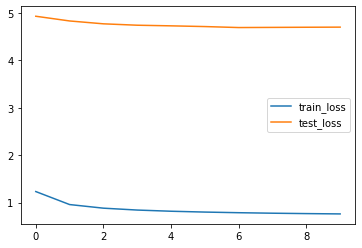

In [17]:
# plot the loss and acc
plot_loss(train_loss_history, test_loss_history, 'Clamer_contrastive_loss')

In [18]:
# save the history to the csv file in log folder
history = pd.DataFrame({'train_loss': train_loss_history, 'train_acc': train_acc_history, 'test_loss': test_loss_history, 'test_acc': test_acc_history, 'train_ce_loss': train_ce_loss_history, 'test_ce_loss': test_ce_loss_history, 'train_info_loss': train_info_loss_history, 'test_info_loss': test_info_loss_history})
history.to_csv(log_dir + 'clamer_contrastive_history.csv', index=False)